In [122]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics 

import pylab

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import os


In [45]:
def plot_mel_power_spectogram(file):

    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('data') + '/' + file )

    y, sr = librosa.load(file_name)

    # Let's make and display a mel-scaled power (energy-squared) spectrogram
    S = librosa.feature.melspectrogram(y, sr=sr, n_mels=128)
    
    mel = np.mean(librosa.feature.melspectrogram(y, sr=sr).T,axis=0)

    # Convert to log scale (dB). We'll use the peak power as reference.
    log_S = librosa.amplitude_to_db(S, ref=np.max)

    # Make a new figure
    plt.figure(figsize=(12,4))

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel')

    # Put a descriptive title on the plot
    plt.title('mel power spectrogram')

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

In [14]:
def extract_features(file):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('data')+'/'+ file )

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    #label = files.label

    return mfccs, chroma, mel, contrast, tonnetz

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


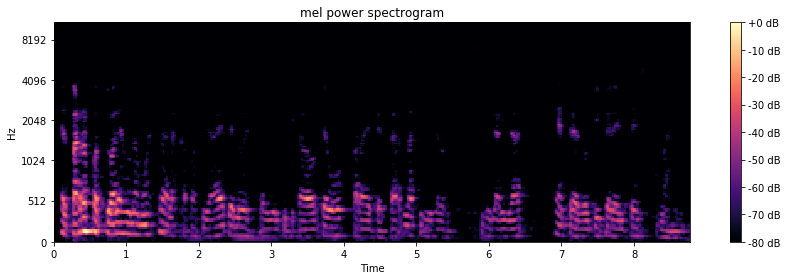

In [46]:
plot_mel_power_spectogram('cortiz_baseline.m4a')

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


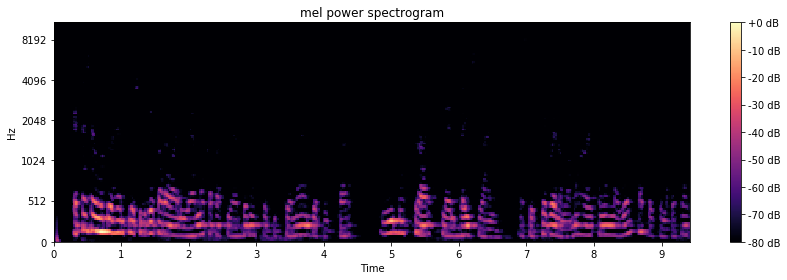

In [42]:
plot_mel_power_spectogram('cortiz_validation.m4a')

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


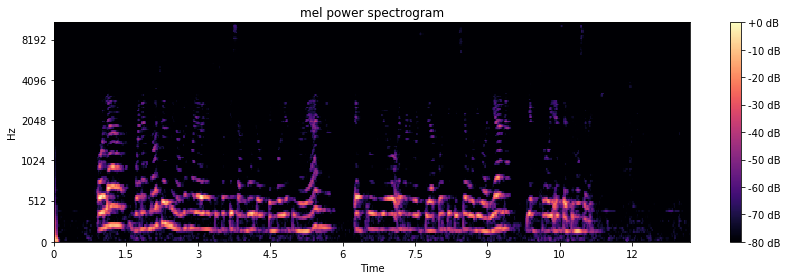

In [135]:
plot_mel_power_spectogram('mary_1.m4a')

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


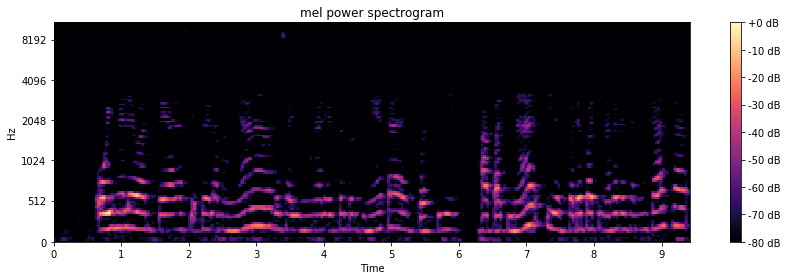

In [136]:
plot_mel_power_spectogram('mary_2.m4a')

In [138]:
# Applying the function to the train data by accessing each row of the dataframe
features_label = extract_features('cortiz_baseline.m4a')
features_label2 = extract_features('cortiz_validation.m4a')
features_label3 = extract_features('mary_1.m4a')
features_label4 = extract_features('mary_2.m4a')

/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/opt/anaconda3/lib/python3.7/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [139]:
features_label = np.array(features_label)
features_label2 = np.array(features_label2)
features_label3 = np.array(features_label3)
features_label4 = np.array(features_label3)

In [140]:
features_label = np.stack((features_label,features_label2,features_label3,features_label4),axis=0)

In [141]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 

features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],features_label[i][4]), axis=0))

In [142]:
features = np.array(features)

In [143]:
features.shape

(4, 193)

In [144]:
df = pd.DataFrame(data=features)

In [145]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,-227.759140,129.924850,8.032254,29.613798,21.191380,3.953542,-16.470751,-11.107962,-17.682335,9.392035,...,16.047259,20.067774,23.751998,35.782126,0.020121,-0.025077,0.019029,0.109600,-0.003592,-0.021066
1,-260.422272,123.324776,31.642073,34.018402,25.527672,9.611577,-14.853857,-9.437029,-18.422346,0.853200,...,15.515939,18.667848,22.231572,36.571859,-0.027879,-0.025956,-0.005062,0.030355,0.012131,-0.043243
2,-349.395508,123.057831,-6.268221,24.977287,14.032900,-0.026072,-16.113953,4.086526,-14.981836,-0.704278,...,15.604205,17.687332,18.944880,31.531496,0.033502,0.033912,-0.004749,0.016524,0.015276,-0.029151
3,-349.395508,123.057831,-6.268221,24.977287,14.032900,-0.026072,-16.113953,4.086526,-14.981836,-0.704278,...,15.604205,17.687332,18.944880,31.531496,0.033502,0.033912,-0.004749,0.016524,0.015276,-0.029151


In [146]:
ss = StandardScaler()
X_train = ss.fit_transform(df)

In [147]:
df = pd.DataFrame(data=X_train)

In [148]:
df

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,1.279757,1.730858,0.080536,0.323929,0.508299,0.145699,-0.947899,-1.112608,-0.748207,1.712044,...,1.705794,1.579403,1.329583,0.824068,0.210305,-0.985147,1.731918,1.713536,-1.708550,1.200885
1,0.673807,-0.516359,1.604382,1.496204,1.391659,1.578639,1.682710,-0.880656,-1.223369,-0.323197,...,-0.851859,0.143846,0.603370,1.161637,-1.691013,-1.014744,-0.597525,-0.333047,0.301428,-1.577061
2,-0.976782,-0.607249,-0.842459,-0.910067,-0.949979,-0.862169,-0.367406,0.996632,0.985788,-0.694424,...,-0.426968,-0.861625,-0.966477,-0.992852,0.740354,0.999945,-0.567196,-0.690245,0.703561,0.188088
3,-0.976782,-0.607249,-0.842459,-0.910067,-0.949979,-0.862169,-0.367406,0.996632,0.985788,-0.694424,...,-0.426968,-0.861625,-0.966477,-0.992852,0.740354,0.999945,-0.567196,-0.690245,0.703561,0.188088


In [149]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
count,4.000000,4.000000e+00,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000e+00,4.000000,4.000000,...,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000,4.000000,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00
mean,0.000000,-5.551115e-17,0.000000,0.000000,0.000000,0.000000,0.000000,5.551115e-17,0.000000,0.000000,...,8.548717e-15,-1.831868e-15,8.881784e-16,-7.771561e-16,0.000000,0.000000,-5.551115e-17,-5.551115e-17,5.551115e-17,1.110223e-16
std,1.154701,1.154701e+00,1.154701,1.154701,1.154701,1.154701,1.154701,1.154701e+00,1.154701,1.154701,...,1.154701e+00,1.154701e+00,1.154701e+00,1.154701e+00,1.154701,1.154701,1.154701e+00,1.154701e+00,1.154701e+00,1.154701e+00
min,-0.976782,-6.072495e-01,-0.842459,-0.910067,-0.949979,-0.862169,-0.947899,-1.112608e+00,-1.223369,-0.694424,...,-8.518591e-01,-8.616247e-01,-9.664766e-01,-9.928524e-01,-1.691013,-1.014744,-5.975255e-01,-6.902445e-01,-1.708550e+00,-1.577061e+00
25%,-0.976782,-6.072495e-01,-0.842459,-0.910067,-0.949979,-0.862169,-0.512529,-9.386436e-01,-0.866997,-0.694424,...,-5.331904e-01,-8.616247e-01,-9.664766e-01,-9.928524e-01,-0.265024,-0.992546,-5.747786e-01,-6.902445e-01,-2.010669e-01,-2.531993e-01
50%,-0.151488,-5.618043e-01,-0.380962,-0.293069,-0.220840,-0.358235,-0.367406,5.798809e-02,0.118791,-0.508810,...,-4.269675e-01,-3.588891e-01,-1.815531e-01,-8.439231e-02,0.475329,0.007399,-5.671963e-01,-5.116456e-01,5.024945e-01,1.880878e-01
75%,0.825294,4.544518e-02,0.461497,0.616998,0.729139,0.503934,0.145123,9.966317e-01,0.985788,0.185613,...,1.062229e-01,5.027356e-01,7.849235e-01,9.084601e-01,0.740354,0.999945,7.582300e-03,1.785989e-01,7.035614e-01,4.412872e-01
max,1.279757,1.730858e+00,1.604382,1.496204,1.391659,1.578639,1.682710,9.966317e-01,0.985788,1.712044,...,1.705794e+00,1.579403e+00,1.329583e+00,1.161637e+00,0.740354,0.999945,1.731918e+00,1.713536e+00,7.035614e-01,1.200885e+00
